In [ ]:
#IMPORTANT: RUN THESE ANSWERS CONSECUTIVELY AS SOME ANSWERS OR DEFINITIONS ARE REUSED IN THE FOLLOWING QUESTION
#IF YOU DONT RUN ALL THE CODE BEFORE A CERTAIN PART, YOU MIGHT GET AN ERROR

In [1]:
from os import access
import pandas as pd
import numpy as np
import datetime
from pandas.core.reshape.concat import concat
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from datetime import date, datetime,timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
!pip install haversine
import haversine as hs
from itertools import permutations, combinations
from collections import Counter
!pip install pandas MLxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [2]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping EmployeeData (HVC_AM0)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

#Reading the file and storing each line in the list text
with open ("HVC_AM0.csv", "r") as f:
    textEmployees = f.readlines()
textEmployees.pop(0)

#We make a dictionnary based on the data
CompanyEmployeesDict = {}

for e in textEmployees:
    Employee_ID, EmployeeNumber, Name, Postcode, Location, Language = e.replace("\n","").split(";")
    Employee_ID=int(Employee_ID)
    Postcode=int(Postcode)
    CompanyEmployeesDict[Employee_ID]= {"EmployeeNumber":EmployeeNumber,"Name": Name, "Postcode": Postcode, "Location": Location,"Language": Language }


#Some Employees do not have a EmployeeNumber: We set the EmployeeNumber of these employees to 0
#In this way we can convert all to a float
for e in CompanyEmployeesDict:
    E_ID = CompanyEmployeesDict[e]["EmployeeNumber"]
    if(E_ID == ""):
        CompanyEmployeesDict[e]["EmployeeNumber"]="0"
    CompanyEmployeesDict[e]["EmployeeNumber"] = int(float(CompanyEmployeesDict[e]["EmployeeNumber"]))   

df_CompanyEmployees = pd.DataFrame.from_dict(CompanyEmployeesDict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping ProductData (HVC_AR0)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("HVC_AR0.csv", "r") as f:
    textProducts = f.readlines()
textProducts.pop(0)

CompanyProductsDict = {}
for e in textProducts:
    ProductID, Description, Category, Family, Price = e.replace("\n","").split(";")
    ProductID = int(ProductID)
    CompanyProductsDict[ProductID]= {"Description":Description,"Category": Category, "Family": Family, "Price": Price}
   
#Some prices are missing   
for e in CompanyProductsDict:
  PriceCheck = CompanyProductsDict[e]["Price"]
  if(PriceCheck==""):
        CompanyProductsDict[e]["Price"]="0.0"
  CompanyProductsDict[e]["Price"]=float(CompanyProductsDict[e]["Price"])  

#Whenever they are Coupons they are not assigned a family
#We assign Coupon to its Family for clearity
for e in CompanyProductsDict:
  PriceCheck = CompanyProductsDict[e]["Family"]
  if(PriceCheck==""):
        CompanyProductsDict[e]["Family"]="Coupon"

df_Products = pd.DataFrame.from_dict(CompanyProductsDict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Reviews Data (HVC_CUSTOMER_REVIEWS)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------   


with open ("HVC_CUSTOMER_REVIEWS.csv", "r") as f:
    textCustReviews = f.readlines()
textCustReviews.pop(0)

CompanyReviewsDict = {}
for e in textCustReviews:
    CustomerID, Review  = e.replace("\n","").split(";")
    CustomerID = int(CustomerID)
    CompanyReviewsDict[CustomerID]= {"Review": Review}

df_Reviews = pd.DataFrame.from_dict(CompanyReviewsDict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Depot data (HVC_DEPOT)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


#Reading the file and storing each line in the list text
with open ("HVC_DEPOT.csv", "r") as f:
    text_Depot = f.readlines()
text_Depot.pop(0)

#We make a dictionnary based on the data
Depot_Dict = {}

for dep in text_Depot:
    Depot_Id, Depot_Location, Depot_Route = dep.replace("\n","").split(";")
    Depot_Id = int(Depot_Id)
    Depot_Route = int(Depot_Route)
    Depot_Dict[Depot_Id] = {"DEPOT":Depot_Location, "HVROUTETEMPLATE_NRID":Depot_Route}

#The Depot_Id and HVROUTETEMPLATE_NRID are both integers, Depot_Location
#The names of the keys are based on the table descriptions for easy looking up in case of further calculations
#There are no missing values in our dictionnary so further preprocessing is not necessary.

df_Depot = pd.DataFrame.from_dict(Depot_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping DaysOfWeek (HVC_HVDAYOFWEEK)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("HVC_HVDAYOFWEEK.csv", "r") as f:
    text_DayOfWeek = f.readlines()
text_DayOfWeek.pop(0)

#We make a dictionnary based on the data
DayOfWeek_Dict = {}

for day in text_DayOfWeek:
    HVDAYOFWEEK_NRID, DAY = day.replace("\n","").split(";")
    HVDAYOFWEEK_NRID = int(float(HVDAYOFWEEK_NRID))
    DayOfWeek_Dict[int(HVDAYOFWEEK_NRID)] = DAY


#The HVDAYOFWEEK_NRID is an integer, DAY is a string. 
#!! important notice for further caclulations, the first day (day with id = 1) is a sunday! Not a monday!
df_DaysOfWeek = pd.DataFrame.from_dict(DayOfWeek_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Position data (HVC_HVPOSITION)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("HVC_HVPOSITION_CORRECT.csv", "r") as f:
    text_Position = f.readlines()
text_Position.pop(0)

#We make a dictionnary based on the data
Position_Dict = {}

for loc in text_Position:
    SO0_NRID, LONG, LAT = loc.replace("\n","").split(";")
    SO0_NRID = int(float(SO0_NRID))
    LONG = float(LONG)
    LAT = float(LAT)
    Position_Dict[SO0_NRID] = {"LONG":LONG, "LAT":LAT}

#SO0_NRID is int, LONG and LAT are both float values.

df_Position = pd.DataFrame.from_dict(Position_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Route Template data (HVC_HVROUTETEMPLATE)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("HVC_HVROUTETEMPLATE.csv", "r") as f:
    textRouteTemplate = f.readlines()
    textRouteTemplate.pop(0)
    
RouteTemplate_Dict = {}

for route in textRouteTemplate:
    HVROUTETEMPLATE_NRID, REGION, WEEKORDER, HVDAYOFWEEK_NRID = route.replace("\n","").split(";")
    HVROUTETEMPLATE_NRID=int(float(HVROUTETEMPLATE_NRID))
    RouteTemplate_Dict[HVROUTETEMPLATE_NRID] = {"REGION": REGION, "WEEKORDER": WEEKORDER, "DAYOFWEEK_NRID": HVDAYOFWEEK_NRID}        

df_RouteTemplate = pd.DataFrame.from_dict(RouteTemplate_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Visit Outcome data (HVC_HVVISITOUTCOME)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("HVC_HVVISITOUTCOME.csv", "r") as f:
    textVisitOutcome = list()
    for line in f:
        line = line.replace("\n","")
        obs = line.split(";")
        textVisitOutcome.append(obs)

column_names = textVisitOutcome[0]
textVisitOutcome.pop(0)
VisitOucome_Dict = {}

for visit in textVisitOutcome:
    VisitOucome_Dict[visit[1]] = visit[0]


df_VisitOutcome = pd.DataFrame.from_dict(VisitOucome_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping TransactionData (HVC_HVVISITRESULT)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


#Reading the file and storing each line in the list text
with open ("HVC_HVVISITRESULT.csv", "r") as f:
    textVisit = f.readlines()
textVisit.pop(0)

#We make a dictionnary based on the data
CompanyVisitDict = {}

for e in textVisit:
    Visit_ID, Customer_ID, Employee_ID, VisitOutcome_ID, Time, Date, Amount, paymentMethod = e.replace("\n","").split(";")
    Visit_ID= int(Visit_ID)

    yYear, mMonth, dDay = Date.split("-")
    yYear = int(yYear)
    mMonth = int(mMonth)
    dDay = int(dDay)
    Date=date(yYear,mMonth,dDay)

    Customer_ID= int(Customer_ID)
    Employee_ID= int(Employee_ID)
    VisitOutcome_ID= int(VisitOutcome_ID)
    Amount= float(Amount)
    CompanyVisitDict[Visit_ID]= {"Customer_ID":Customer_ID,"Employee_ID": Employee_ID, "VisitOutcome_ID": VisitOutcome_ID, "Time": Time,"Date": Date, "Amount": Amount, "paymentMethod": paymentMethod }

#Some visits do not have a payment method recorded: We set the paymentMethod of these cases to the None variable
#Maybe these missing values will have value later on
for e in CompanyVisitDict:
    P_method = CompanyVisitDict[e]["paymentMethod"]
    if(P_method == ""):
        CompanyVisitDict[e]["paymentMethod"]= None

df_CompanyVisit = pd.DataFrame.from_dict(CompanyVisitDict, orient = 'index')

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping EmployeeData (HVC_SO0)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


#Reading the file and storing each line in the list text
with open ("HVC_SO0.csv", "r") as f:
    textCustomerType = f.readlines()
textCustomerType.pop(0)

#We make a dictionnary based on the data
CustomerTypeDict = {}

for e in textCustomerType:
    Customer_ID, RouteTemplate_ID, CustomerType, Postcode, Language, Season = e.replace("\n","").split(";")
    Customer_ID=int(float(Customer_ID))
    RouteTemplate_ID=int(float(RouteTemplate_ID))
    Postcode = int(float(Postcode))
    CustomerTypeDict[Customer_ID]= {"RouteTemplate_ID":RouteTemplate_ID,"CustomerType": CustomerType, "Postcode": Postcode, "Language": Language,"Season": Season}


df_CustomerType = pd.DataFrame.from_dict(CustomerTypeDict, orient = 'index')

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping ProductData (HVC_VISITRESULTDETAILS)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("HVC_VISITRESULTDETAILS.csv", "r") as f:
    textVisitDetails = f.readlines()
textVisitDetails.pop(0)


#We make a dictionnary based on the data
VisitDetailsDict = {}


for e in textVisitDetails:
    VisitDetails_ID, Product_ID, Quantity, Visit_ID = e.replace("\n","").split(";")
    VisitDetails_ID=int(VisitDetails_ID)
    Product_ID=int(Product_ID)
    Quantity=int(float(Quantity))
    Visit_ID=int(float(Visit_ID))
    VisitDetailsDict[VisitDetails_ID]= {"Product_ID":Product_ID,"Quantity": Quantity, "Visit_ID": Visit_ID}

df_VisitDetails = pd.DataFrame.from_dict(VisitDetailsDict, orient = 'index')


#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#This gives us the following 11 dataframes to work with:
# 1  df_CompanyEmployees (HVC_AM0)
# 2  df_Products (HVC_AR0)
# 3  df_Reviews  (HVC_CUSTOMER_REVIEWS)
# 4  df_Depot  (HVC_DEPOT)
# 5  df_DaysOfWeek (HVC_HVDAYOFWEEK)
# 6  df_Position (HVC_HVPOSiTION)
# 7  df_RouteTemplate (HVC_HVROUTETEMPLATE)
# 8  df_VisitOutcome (HVC_HVVISITOUTCOME)
# 9  df_CompanyVisit (HVC_VISITRESULT)
# 10 df_CustomerType (HVC_SO0)
# 11 df_VisitDetails (HVC_VISITRESULTDETAILS)

#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [3]:
########################
#Q4 What are the routes?
########################

In [4]:
#Let's start by merging the df_RouteTemplate datdabse with the other two databases (CustomerType and Depotfor closer detail
#The merge is done via the equally named column "HVROUTETEMPLATE_NRID" in all databases.
#However the df_RouteTemplate contains these ID's in the first column, was this was the list of keys from our dictionary
#This results in the first column having no columname to merge with other databases. To solve this we can copy this column.
#After we copied this column we can add it to our original database, we now have duplicate column with which we can work with.
df_RouteTemplate["RouteTemplate_ID"] = df_RouteTemplate.index
df_Depot=df_Depot.rename(columns={"HVROUTETEMPLATE_NRID": "RouteTemplate_ID"})

#next we will merge the two databases df_RouteTemplate and df_CustomerType in order to link our customer and route info
df_CustomerType["CustomerID"]=df_CustomerType.index
df_Customer_Route = pd.merge(df_CustomerType, df_RouteTemplate, how = "left", on = "RouteTemplate_ID")
#for future question we will also need the depot so that's why we join them as well
df_Customer_Route_Depot = pd.merge(df_Depot, df_Customer_Route, how = "left", on = "RouteTemplate_ID")
df_CustomerType.head(5)
#df_Customer_Route.head(5)
#increasing the view of our dataframe, set the parameters if you want less rows to be visible
# pd.set_option("display.max_rows", None, "display.max_columns", None)

,RouteTemplate_ID,CustomerType,Postcode,Language,Season,CustomerID
721104,219020601,Private,3930,nl-BE,All time,721104
721110,219020601,Private,3930,nl-BE,All time,721110
721121,219020601,Private,3930,nl-BE,All time,721121
721126,219020601,Private,3930,nl-BE,All time,721126
721131,219020601,Private,3930,nl-BE,All time,721131


In [5]:
#Q4.1 How are the customers divided into regions?
#here we can see that every customer has its own routenumber, postcode, region, weekorder and dayofweek. 
#If we make a subselection of our total database and remove all duplicates for our region and postcode,
#we can find a database that shows us each region linked to each unique postcode, as we assumed (see picture of map)
#all unique postcodes are clustered in 4 groups en each cluster of postcodes corresponds to the same region!
#so to answer: The postcode of a customer determines its REGION
df_Customer_Route_Depot.drop_duplicates(subset = ["Postcode", "REGION"]).sort_values(by="REGION")

,DEPOT,RouteTemplate_ID,CustomerType,Postcode,Language,Season,CustomerID,REGION,WEEKORDER,DAYOFWEEK_NRID
3468,Vilvoorde,289419955,Private,3550,nl-BE,All time,1249654,B02,2.0,6.0
1279,Deinze,289414945,Private,3582,nl-BE,All time,1245116,B02,1.0,6.0
3140,Vilvoorde,289416949,Private,3580,nl-BE,All time,687782,B02,2.0,3.0
1815,Antwerpen,289756470,Private,3670,nl-BE,All time,878365,B25,1.0,3.0
3401,Vilvoorde,289761480,Private,3668,nl-BE,All time,870198,B25,2.0,3.0
1406,Deinze,289757472,Private,3640,nl-BE,All time,1451889,B25,1.0,4.0
1414,Deinze,289757472,Private,3960,nl-BE,All time,56963283,B25,1.0,4.0
1474,Deinze,289757472,Private,3680,nl-BE,All time,56366188,B25,1.0,4.0
1804,Antwerpen,289756470,Private,3660,nl-BE,All time,876603,B25,1.0,3.0
2327,Antwerpen,289763484,Private,3650,nl-BE,All time,877993,B25,2.0,5.0


In [6]:
#Q4.2 Which customers are assigned to which routes?
df_Customer_Route_Depot.drop_duplicates(subset = ["RouteTemplate_ID", "WEEKORDER", "DAYOFWEEK_NRID"]).sort_values(by=["RouteTemplate_ID", "WEEKORDER", "DAYOFWEEK_NRID"])
df_Customer_Route_Depot.drop_duplicates().sort_values(by=["RouteTemplate_ID", "WEEKORDER", "DAYOFWEEK_NRID"])
df_CRV = pd.merge(df_CustomerType, df_Customer_Route_Depot, on="RouteTemplate_ID").drop(columns=["Postcode_x","CustomerID_x","CustomerType_x","Language_x","Season_x"])
df_CRV.sort_values(by=["CustomerID_y"])
df_CRV.head(5)

,RouteTemplate_ID,DEPOT,CustomerType_y,Postcode_y,Language_y,Season_y,CustomerID_y,REGION,WEEKORDER,DAYOFWEEK_NRID
0,219020601,Deinze,Private,3930,nl-BE,All time,721104,C04,1.0,5.0
1,219020601,Deinze,Private,3930,nl-BE,All time,721110,C04,1.0,5.0
2,219020601,Deinze,Private,3930,nl-BE,All time,721121,C04,1.0,5.0
3,219020601,Deinze,Private,3930,nl-BE,All time,721126,C04,1.0,5.0
4,219020601,Deinze,Private,3930,nl-BE,All time,721131,C04,1.0,5.0


In [7]:
#Q4.3 Which routes are assigned to which depots?
#In the dataframe below we can see for each depot every single possible route, the total number of routes in the dataframe is
#39 which corresponds to the df_RouteTemplate dataframe, where there were 39 possible routes
#This shows that every route is linked to a certain depot
df_Customer_Route_Depot.drop_duplicates(subset = ["DEPOT", "RouteTemplate_ID"]).sort_values(by = "DEPOT")
#len(df_Customer_Route_Depot.drop_duplicates(subset = ["DEPOT", "RouteTemplate_ID"]).sort_values(by = "DEPOT").index)

,DEPOT,RouteTemplate_ID,CustomerType,Postcode,Language,Season,CustomerID,REGION,WEEKORDER,DAYOFWEEK_NRID
5678,Aarschot,289657598,Private,3500,nl-BE,All time,1403584,C17,1.0,4.0
5380,Aarschot,289662608,Private,3500,nl-BE,All time,871717,C17,2.0,4.0
5281,Aarschot,289663610,Private,3500,nl-BE,All time,701859,C17,2.0,5.0
5541,Aarschot,289658600,Private,3500,nl-BE,All time,1403388,C17,1.0,5.0
2974,Antwerpen,289760478,Private,3680,nl-BE,All time,1450605,B25,2.0,2.0
2650,Antwerpen,289762482,Private,3680,nl-BE,All time,879566,B25,2.0,4.0
2480,Antwerpen,289758474,Private,3650,nl-BE,All time,878045,B25,1.0,5.0
2327,Antwerpen,289763484,Private,3650,nl-BE,All time,877993,B25,2.0,5.0
2155,Antwerpen,289759476,Private,3680,nl-BE,All time,877412,B25,1.0,6.0
1978,Antwerpen,289755468,Private,3680,nl-BE,All time,877215,B25,1.0,2.0


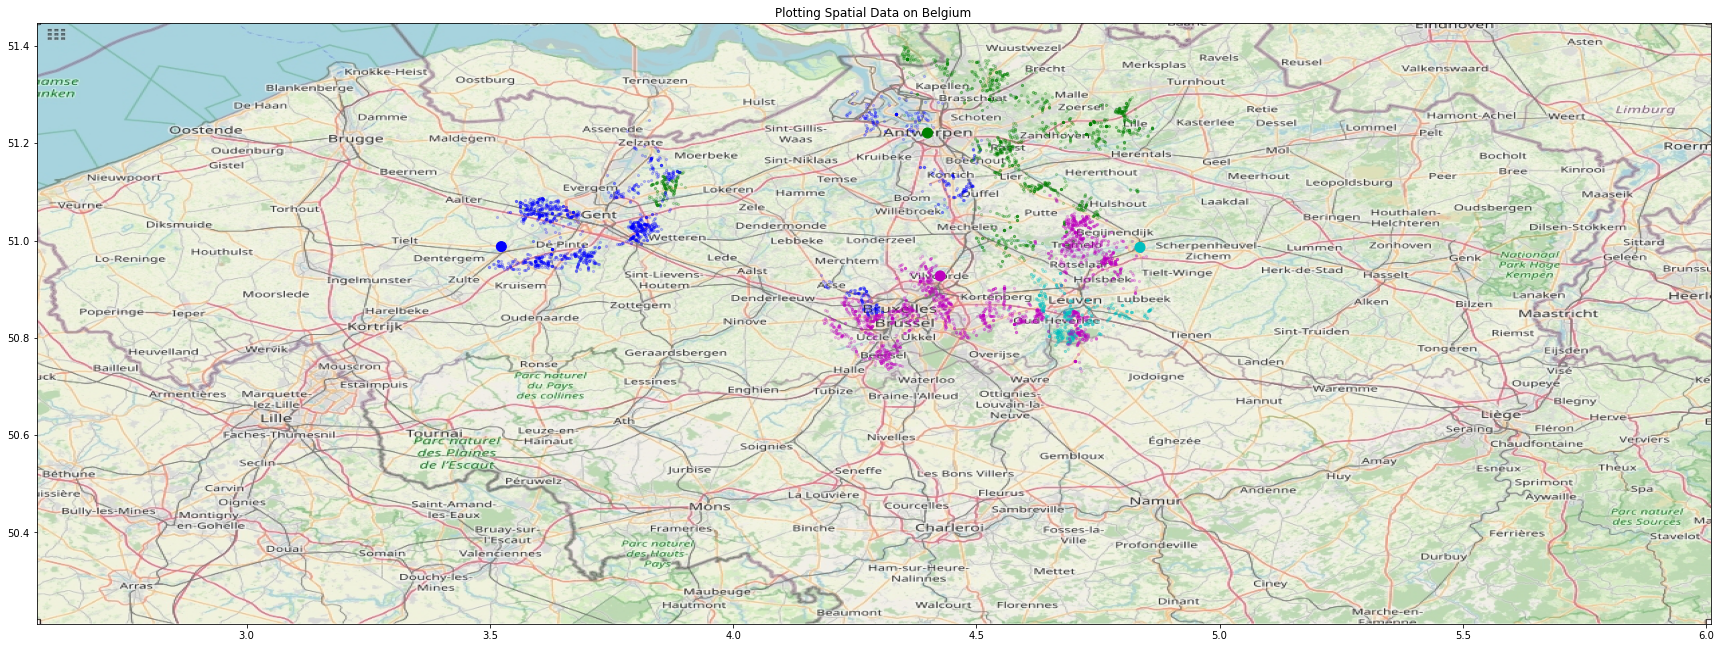

In [9]:
#Lets plot the customers again this time, however now we are going to colour match all the customers based on which depot
#makes their deliveries!

#initialize the dataframe and merge it with the customer rout depot from Q4 in order to link customer ID and the city of the depot
df_Position["CustomerID"] = df_Position.index

df_customer_locations = pd.merge(df_Customer_Route_Depot,df_Position, how = "left", on = "CustomerID").drop(
    columns = ["RouteTemplate_ID", "Postcode", "Language", "Season", "WEEKORDER", "DAYOFWEEK_NRID"])

#we now create 4 seperate datafrmes which each contain all the coordinates of the people that get deliverd by this depot
df_deinze = df_customer_locations[df_customer_locations["DEPOT"].str.contains("Deinze")]
df_antwerpen = df_customer_locations[df_customer_locations["DEPOT"].str.contains("Antwerpen")]
df_aarschot = df_customer_locations[df_customer_locations["DEPOT"].str.contains("Aarschot")]
df_vilvoorde = df_customer_locations[df_customer_locations["DEPOT"].str.contains("Vilvoorde")]

#We plot all coordinates based on a colorschema
fig, ax = plt.subplots(figsize = (30,50))
ax.scatter(df_deinze.LONG, df_deinze.LAT, zorder=1, alpha= 0.2, c='b', s=5)  #deinze is blauw
ax.scatter(df_antwerpen.LONG, df_antwerpen.LAT, zorder=1, alpha= 0.2, c='g', s=5)   #antwerpen groen
ax.scatter(df_aarschot.LONG, df_aarschot.LAT, zorder=1, alpha= 0.2, c='c', s=5)   #aarschot cyan
ax.scatter(df_vilvoorde.LONG, df_vilvoorde.LAT, zorder=1, alpha= 0.2, c='m', s=5)  #vilvoorde roze

directory = "ma.jpg"       #SET DIRECTORY VOOR WAAR UW LEGE MAP OPGESLAGEN IS
afb = plt.imread(directory)

ax.set_title('Plotting Spatial Data on Belgium')
ax.set_xlim(2.5681,6.0095)
ax.set_ylim(50.2121,51.4472)
ax.scatter([3.5235857, 4.3997081, 4.8365218, 4.4257868],                    #coordinaten van respectievelijk DEINZE, ANTWERPEN, 
            [50.9875406, 51.2211097, 50.9859959, 50.9272511],               #Aarschot en Vilvoorde
           zorder = 1, c = ["b", "g", "c", "m"], s=100)   
ax.imshow(afb, zorder=0, extent = (2.5681,6.0095,50.2121,51.4472), aspect= 'equal')